In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision
from torchvision import transforms
import sys
import os, json, glob
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)
from utils import cv_from_binary

import pandas as pd
import numpy as np

In [2]:
for d in sorted(os.scandir(os.path.join('..','history')), key=lambda x:x.path, reverse=True):
    data_path = os.path.join(d.path, 'dataset.pkl')
    if os.path.exists(data_path):
        print(f'The most recent simulation folder has been selected "{d.path}":')
        df = pd.read_pickle(data_path)
        dataset = df.loc[~df['out_of_map'],['image','target_map']]
        dataset.head()
        break

The most recent simulation folder has been selected "../history/1205-002637":


## ML Dataset

In [3]:
def _moveaxis(tensor: torch.Tensor, source: int, destination: int) -> torch.Tensor:
    dim = tensor.dim()
    perm = list(range(dim))
    if destination < 0:
        destination += dim
    perm.pop(source)
    perm.insert(destination, source)
    return tensor.permute(*perm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 240, 320]) -2.0357141 1.9951199
Total data: 231818, train batches: 11519


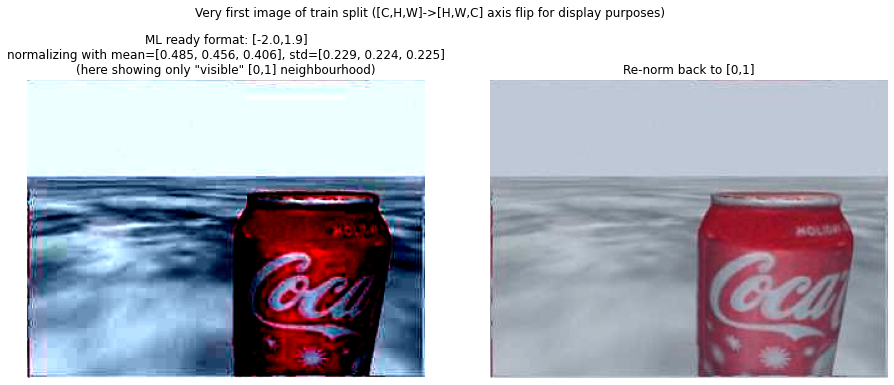

In [4]:
import torch
import matplotlib.pyplot as plt
def transform(x):
    x = cv_from_binary(x)
    # x = np.moveaxis(x,-1,0)
    
    # Images of shape (3 x H x W), where H and W are expected to be at least 224
    mobilenet_v2_format = transforms.Compose([
        #transforms.ToPILImage(), # Tensor of shape C x H x W or a numpy ndarray of shape H x W x C
        #transforms.Resize(256),transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return mobilenet_v2_format(x)

class ConvDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.X = images.values
        if labels is not None:
            labels = labels.map(lambda x: torch.as_tensor(x, dtype=torch.float32)).values
        self.y = labels
        self.transform = transform
         
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X[i]
        
        if self.transform is not None:
            data = self.transform(data)
        
        if self.y is not None:
            return data, self.y[i]
        else:
            return data

cd = ConvDataset(dataset['image'], labels=dataset['target_map'], transform=transform)
train_val = [int(len(cd)*x) for x in [0.795,0.05]] # train, val
train_val_test = train_val + [len(cd)-sum(train_val)] # test
batch_size = 16
train_loader, val_loader, test_loader = [DataLoader(x, batch_size=batch_size, shuffle=True) for x in torch.utils.data.dataset.random_split(cd,train_val_test)]
fig, axs = plt.subplots(1,2, figsize=(13,5))
for X, y in train_loader:
    print(X.shape, X.numpy().min(), X.numpy().max())
    X = _moveaxis(X[0],0,-1)
    axs[0].imshow(X)
    axs[0].set_title(f'ML ready format: [{X.min():1.1f},{X.max():1.1f}]\nnormalizing with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]'+\
                     f'\n(here showing only "visible" [0,1] neighbourhood)')
    axs[0].axis('off')
    X = (X - X.min())/(X.max()-X.min())
    axs[1].imshow(X)
    axs[1].set_title(f'Re-norm back to [0,1]')
    axs[1].axis('off')
    plt.tight_layout()
    plt.suptitle('Very first image of train split ([C,H,W]->[H,W,C] axis flip for display purposes)', y=1.07)
    break
print(f'Total data: {len(cd)}, train batches: {len(train_loader)}')
plt.show()

# Models

### Pretrained MobileNetV2 (frozen convolutional layers)

In [5]:
import torch
device = 'cpu'
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
model.to(device)
display(list(model._modules.keys()))
for param in model.features.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 400)
)

Using cache found in /Users/ste/.cache/torch/hub/pytorch_vision_master


['features', 'classifier']

In [7]:
import importlib

In [41]:

import model
importlib.reload(model)
from model import BayesConvNet

irs = [[1, 8, 1, 1],
       [6, 16, 2, 2],
       [6, 24, 3, 2],
       [6, 32, 1, 1]]

model = BayesConvNet(irs, in_planes=200, out_planes=250,
                     samples=2, num_classes=400, mode='softmax')
print('Total model parameters:', sum(p.numel() for p in model.parameters()))

# output = model(torch.randn(16, 3, 240, 320))
# print(output)
X, y = next(iter(train_loader))

output = model(X)
output[0].shape

Keys recovered from the pretrained model state that are still compatible: 33
32
LogSoftmax function has been appended
Total model parameters: 1148112


torch.Size([16, 400, 2])

In [52]:
import torch.optim as optim
from bnn import nn
loss_function = torch.nn.NLLLoss()
kld_function = nn.KLDivergence(number_of_batches=1)
get_entropy = nn.Entropy(dim=-1)

first_sample = output[0]
mask = (y > -1)

# divergence = kld_function(model)
# likelihood = torch.stack([
#     loss_function(pred[mask], y.type(torch.LongTensor)[mask]) for pred in output
# ]).mean() / model.samples

# loss = likelihood + divergence
# loss.backward()
from sklearn.metrics import roc_auc_score




0.2214251324025036

In [29]:
#    t,  c, n, s
irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]

import torch.optim as optim
for mode, criterion, desired_transform in zip(['softmax','sigmoid'], 
                                       [nn.NLLLoss(), nn.MSELoss()],
                                       [lambda x: x.type(torch.LongTensor), lambda x: torch.stack([1-x, x], dim=2)]):
    
    # Initialize model
    model = conv_net(inverted_residual_setting=irs,                      # major part of the network
                     in_planes=200, out_planes=400, conv_bayes=True,     # our extra convolution
                     num_classes=400, mode=mode, classifier_bayes=False) # classifier parameters
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    
    # Training loop example
    X, y = iter(train_loader).next()
    mask = (y > -1)   
    stacked_y = torch.stack([1-y, y], dim=2)
    
    # Get prediction
    output = model(X)
    
    # Calculate loss
    loss = criterion(output[mask], desired_transform(y)[mask])
    print('Loss:', loss.item())
    print('AUC:', roc_auc_score(stacked_y[mask], output[mask].detach().numpy()))
    
    # Calculate error contribution
    loss.backward()
    
    # Update the weights
    optimizer.zero_grad()
    optimizer.step()

AttributeError: module 'bnn.nn' has no attribute 'NLLLoss'

# Chooose one

In [43]:
print(X.shape)

torch.Size([16, 3, 240, 320])


In [19]:
from datetime import datetime as dt
dt.now().strftime("%m%d%H")

'120916'

In [6]:


irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]
model = torchvision.models.MobileNetV2(num_classes=800)

display(model.features[-2:], model.classifier)
model.features[-1][0].out_channels

Sequential(
  (17): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): ConvBNReLU(
        (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (18): ConvBNReLU(
    (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=800, bias=True)
)

1280

In [15]:
import importlib
import bnn
importlib.reload(bnn)
from bnn import nn as bnn_layers

from sklearn.metrics import roc_auc_score

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

from torch.hub import load_state_dict_from_url
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)
    
class bayes_conv_net(bnn_layers.BayesianNetworkModule, torchvision.models.MobileNetV2):
    def __init__(self, irs, 
                 in_planes, out_planes, samples=12,
                 num_classes=400, mode='softmax', bayes_classifier=False,
                 width_mult = 1, round_nearest = 8):
        
        # Call constructor to build most of the newtork
        super(bayes_conv_net, self).__init__(in_channels=3, out_channels=num_classes, # Popped by BNN
                                             inverted_residual_setting=irs, width_mult=width_mult, round_nearest=round_nearest) # Passed to MobileNetV2
        
        assert len(self.features) < 15, 'Non stai passando corretamente i parametri al costruttore MobileNetv2'
        self.samples = samples
        
        pretrained_dict = load_state_dict_from_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',progress=True)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                           k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict, strict=True)
        
        # Redefine last convolutional block of the original mobilenetv2 architechture
        # In this way, we can control the output channels, they are the input channels of our extra convolution
        last_block_in = _make_divisible(irs[-1][1] * width_mult, round_nearest)
        print(last_block_in)
        #last_block_in=320 # last_block_in * samples?
        self.features[-1] = torchvision.models.mobilenet.ConvBNReLU(last_block_in, in_planes, kernel_size=1)
        
        # Add out study bayesian convolutional block
        self.features.add_module('study', bnn_layers.NormalConv2d(in_planes, out_planes, 3, 1, 1, bias=False))
        
        # Redefine 'classifier' block at end of the network
        # In this way, we can control the input channels, they are the output channels of our extra convolution
        linear_layer = bnn_layers.NormalLinear if bayes_classifier else nn.Linear
        self.classifier = nn.Sequential(
            #Flatten(),
            nn.Dropout(0.2),
            linear_layer(out_planes, num_classes)
        )
        
        # Final touch, if the user requested it
        f = lambda x: x.reshape(-1, 400, 2)
        if mode == 'sigmoid':
            print('Logistic function has been appended')
            def f(x):
                x = nn.Sigmoid()(x)
                x = x.reshape(-1, 400, 2)
                return x
        elif mode == 'softmax':
            print('LogSoftmax function has been appended')
            def f(x):
                x = x.reshape(-1, 400, 2)
                x = nn.LogSoftmax(dim=2)(x)
                return x
        else:
            print(f'Mode \'{mode}\' not supported, will perform only reshape')
        self.final_touch = f
        
        print('Total model parameters:', sum(p.numel() for p in self.parameters()))
        #display(self.features[-3:], self.classifier)
        
    def _forward(self, x):
        x = self._forward_impl(x)
        x = self.final_touch(x)
        return x

# Initialize model
irs=[[1, 8, 1, 1],
    [6, 16, 2, 2],
    [6, 24, 3, 2],
    [6, 32, 1, 1]]
model = bayes_conv_net(irs, 
                       in_planes=200, out_planes=200, samples=12,
                       bayes_classifier=False)
X, y = iter(train_loader).next()
display(bayes_conv_net.mro())
model(X)

32
LogSoftmax function has been appended
Total model parameters: 847712


[__main__.bayes_conv_net,
 bnn.nn.container.BayesianNetworkModule,
 torchvision.models.mobilenet.MobileNetV2,
 torch.nn.modules.module.Module,
 object]

0

In [17]:
X, y = iter(train_loader).next()
X.shape

torch.Size([16, 3, 240, 320])

In [ ]:
import importlib
import bnn
importlib.reload(bnn)
from bnn import nn as bnn_layers

irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]    

class conv_net(bnn_layers.BayesianNetworkModule, torchvision.models.MobileNetV2):
    def __init__(self, inverted_residual_setting, 
                 in_planes, out_planes, bayes, samples=10,
                 num_classes=400, mode='softmax', width_mult = 1, round_nearest = 8):
        
        # Call constructor to build most of the newtork
        super(conv_net, self).__init__(inverted_residual_setting=inverted_residual_setting, 
                                       width_mult=width_mult, round_nearest=round_nearest)
        self.samples = samples
        self.in_channels = in_channels
        self.out_channels = out_channels

model = conv_net(inverted_residual_setting=irs,
                 in_channels=10, out_channels=10,
                 in_planes=200, out_planes=400, bayes=True)


In [ ]:
import inspect
inspect.getsource(bnn_layers.BayesianNetworkModule).split('\n')

In [ ]:
class A:
    def __init__(self,a):
        pass
class B:
    def __init__(self,b):
        pass
class C(A, B):
    def __init__(self,a,b):
        super(C, self).__init__(a=a, b=b)
        
C('a', 'b')

In [ ]:

#    t,  c, n, s
irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]    

# Initialize model
model = torchvision.models.MobileNetV2(inverted_residual_setting=irs, width_mult=1., round_nearest=8)
pretrained_dict = load_state_dict_from_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',progress=True)

model_dict = model.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict, strict=False)

## Setup

# Training, testing first

In [ ]:
from sklearn.metrics import roc_auc_score
import torch.optim as optim

In [ ]:

# import torch.nn.functional as F

# # optimizer
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# # loss function
# criterion = nn.MSELoss(reduction='mean')


In [ ]:
# load sample batch
# data, target = iter(train_loader).next()
# mask = (target > -1)

# # get prediction
# output = model(data)

# # # compute auc
# auc = roc_auc_score(target[mask], output[mask].detach().numpy())
# display(auc)

# # masked loss
# loss = criterion(output[mask], target[mask])
# display(loss.item())

# # reset and comput gradient
# optimizer.zero_grad()
# loss.backward()

# # update network
# optimizer.step()

In [ ]:
epochs = 1

optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss(reduction='mean')

def get_loss_auc(X,y):
    mask = (y > -1)
    output = model(X)
    auc = roc_auc_score(y[mask], output[mask].detach().numpy())
    loss = criterion(output[mask], y[mask])
    return loss, auc

def show_progress(epoch, t, batch_idx, X, loader, loss, auc):
    print(f'\r{t} Epoch: {epoch + 1} [{batch_idx*len(X)}/{len(loader.dataset)} '+
                  f'({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}'+
                  f'\t\tAUC: {auc:.3f}', end='')

train_metrics = []
for epoch in range(epochs):
    model.train()
    try:
        for batch_idx, (X, y) in enumerate(train_loader):
            
            loss, auc = get_loss_auc(X, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_metrics.append([loss.item(), auc])
            
            show_progress(epoch, 'Training', batch_idx, X, train_loader, loss, auc)
            
#             if batch_idx % 1000:
#                 print()
#                 model.eval()
#                 with torch.no_grad():
#                     for batch_idy, (X, y) in enumerate(val_loader):
#                         loss, auc = get_loss_auc(X, y)
#                     show_progress(epoch, 'Validation', batch_idy, X, val_loader, loss, auc)
#                 model.train()
    except KeyboardInterrupt:
        #show_progress(epoch, 'End of training:', batch_idx, X, train_loader, loss, auc)
        print('\nUser stopped the training/validation phase')
    print()
    test_metrics = []
    model.eval() 
    try:
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(test_loader):
                loss, auc = get_loss_auc(X, y)
                test_metrics.append([loss.item(), auc])
                show_progress(epoch, 'Test', batch_idx, X, test_loader, loss, auc)
    except KeyboardInterrupt:
        print('\nUser stopped the testing phase')
print('End of execution')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

def plot_metrics(model_name, train_metrics, test_metrics):
    fig, axs = plt.subplots(2,1,figsize=(10,8))
    def f(ax, metrics):
        df = pd.DataFrame(metrics, index=np.arange(0,len(metrics)*batch_size, batch_size), columns=['loss', 'auc'])
        ax.set_title('Training')
        ax.xaxis.set_major_locator(MultipleLocator(base=batch_size))
        sns.lineplot(data=df['loss'], ax=ax, label='Loss')
        ax.legend(loc=2)
        ax2 = ax.twinx()
        sns.lineplot(data=df['auc'], ax=ax2, color='C1', label='AUC')
        ax2.legend(loc=3)

    f(axs[0], train_metrics)
    f(axs[1], test_metrics)
    plt.suptitle(model_name)

plot_metrics('Pretrained MobileNetv2', train_metrics, test_metrics)

In [ ]:
import torch
model = torch.load('initial_test');

In [ ]:
#run_cd = ConvDataset(run['image'], labels=run['target_map'], transform=transform)
#run_loader = DataLoader(run_cd, batch_size=batch_size, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt, matplotlib.colors as clr
import seaborn as sns
fig, axs = plt.subplots(figsize=(6,6))
axs.axis('off')
X, y = cd[np.random.choice(len(cd))]
pred_omap = model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy()
def normalized_point(dist, x):
    near_one = dist.flat[np.abs(dist - x).argmin()]
    return (near_one - dist.min())/(dist.max()-dist.min())
cmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0, 'white'), 
                                                             (normalized_point(pred_omap, -1), 'grey'),
                                                             (normalized_point(pred_omap, 0), 'green'), 
                                                             (normalized_point(pred_omap, 1),    'red'),
                                                             (normalized_point(pred_omap, +2), 'grey'),
                                                             (1, 'white')], N=256)
sns.heatmap(data=pred_omap, ax=axs, cmap=cmap, cbar=True)
plt.show()

In [ ]:
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [ ]:
ax.collections[0].__dict__.keys()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

user_input = 1
while user_input != '0':
    X, y = cd[np.random.choice(len(cd))]
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].imshow(_moveaxis(X, 0,-1))
    myColors = ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data=y.reshape(20,20), ax=axs[1], cmap=cmap, cbar=False)
    
    
    cmap = clr.LinearSegmentedColormap.from_list('custom', ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0)), N=256)

    sns.heatmap(data=model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy(), ax=axs[2], cbar=False, cmap=cmap)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    user_input = input()

In [ ]:
import analyzer, importlib
importlib.reload(analyzer)
from IPython.display import Video
points_file = os.path.join(d.path, 'points.json')
with open(points_file) as f:
    points_d = json.load(f)
targets = np.array([(c['x'],c['y']) for c in points_d['targets']])

r = np.random.choice(df[~df['out_of_map']]['run'].unique())
run = df[df['run'] == r].copy()
save_path = os.path.join(d.path,'single_runs',f'omap_{r}.mp4')
analyzer.Animator(run, targets, rate=30, save_path=save_path, model=model)
display(Video(save_path))

In [ ]:
for X, y in torch.utils.data.DataLoader(test_loader, batch_size=1, num_workers=0, shuffle=True):
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].imshow(_moveaxis(X, 0,-1))
    sns.heatmap(data=y.reshape(20,20), ax=axs[1], cbar=False)
    sns.heatmap(data=model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy(), ax=axs[2], cbar=False)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    break